# Table of Contents
[1. Get the data](#first-bullet)<br>
[2. Discover and visualize the data to gain insights](#second-bullet)<br>
[3. Prepare the data for ML algorithm](#third-bullet)<br>
[4. Select and Train a model](#fourth-bullet)<br>
[5. Fine-tuning](#fifth-bullet)

In [17]:
import os
import tarfile
from six.moves import urllib

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Get the data <a name="first-bullet"></a>

In [19]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"    # original path
HOUSING_PATH = "datasets/housing"    # local path
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [20]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """ Function that downloads and extracts contect from source url.
    """
    # create directory if not existed
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    # download tar file
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # extract files from tar
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [21]:
fetch_housing_data()

In [22]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [23]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [24]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [25]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [26]:
housing.describe()    # only numerical attributes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


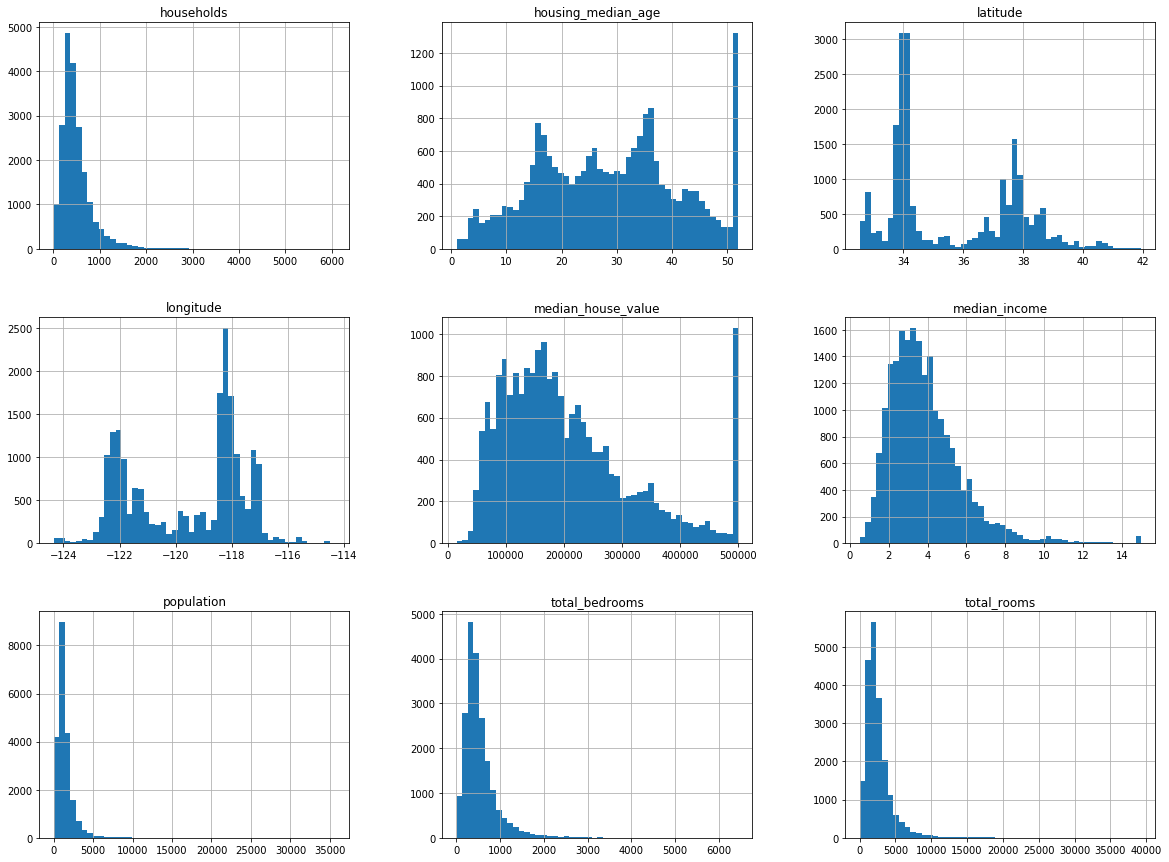

In [27]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

- There exist caps on median age and house values.
- Median income is not in USD $.
- Most histograms are heavy-tailed.

### Partition data

In [28]:
housing['income_cat'] = np.ceil(housing.median_income / 1.5)
housing['income_cat'].where(housing.income_cat < 5, 5.0, inplace=True)

### stratified sampling on income category

In [29]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
train_set.shape, test_set.shape

((16512, 11), (4128, 11))

In [30]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_train_set.shape, strat_test_set.shape

((16512, 11), (4128, 11))

In [31]:
# compare random vs stratified sampling on test sets
comp = pd.DataFrame({'Overall': housing.income_cat.value_counts().sort_index() / len(housing), 
                     'Random sampling' : test_set.income_cat.value_counts().sort_index() / len(test_set),
                     'Stratified sampling' : strat_test_set.income_cat.value_counts().sort_index() / len(strat_test_set)
                    })
comp['Rand. %error'] = (comp['Random sampling'] - comp['Overall']) / comp['Overall'] * 100
comp['Strat. %error'] = (comp['Stratified sampling'] - comp['Overall']) / comp['Overall'] * 100
comp

,Overall,Random sampling,Stratified sampling,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [32]:
for set in (strat_test_set, strat_train_set):
    set.drop(['income_cat'], axis=1, inplace=True)

## 2. Discover and visualize the data to gain insights <a name="second-bullet"></a>

In [33]:
# Now that we have stratified samples for train/test, we can rename housing.
housing = strat_train_set.copy()
housing.shape

(16512, 10)

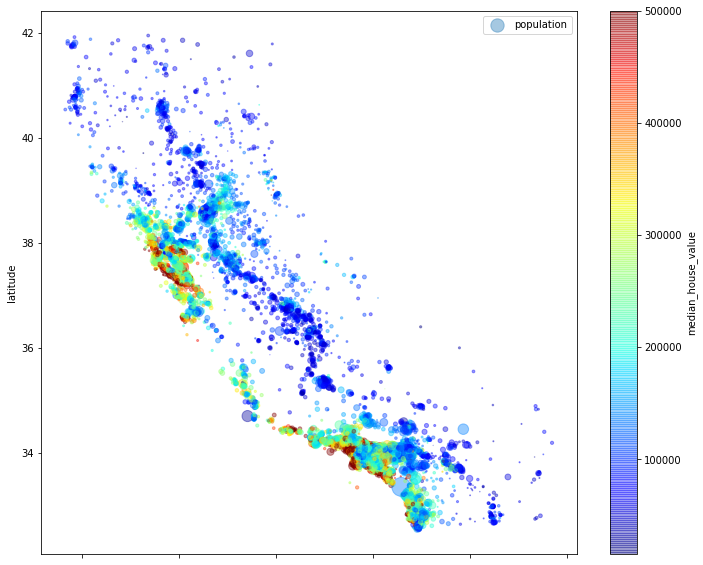

In [34]:
housing.plot.scatter(x='longitude', y='latitude', alpha=0.4,
                    s=housing['population']/100, label="population",
                    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
                    figsize=(12, 10))
plt.legend()

### (Linear) Correlations

In [35]:
corr_mat = housing.corr()
corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

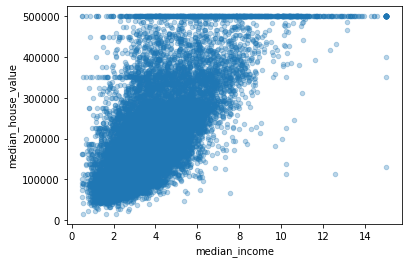

In [36]:
# closely examine the median_income column
housing.plot.scatter(x='median_income', y='median_house_value', alpha=.3)

### Combination of attributes

In [37]:
housing['rooms_per_household'] = housing.total_rooms / housing.households
housing['bedrooms_per_room'] = housing.total_bedrooms / housing.total_rooms
housing['population_per_household'] = housing.population / housing.households

In [38]:
corr_mat = housing.corr()
corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

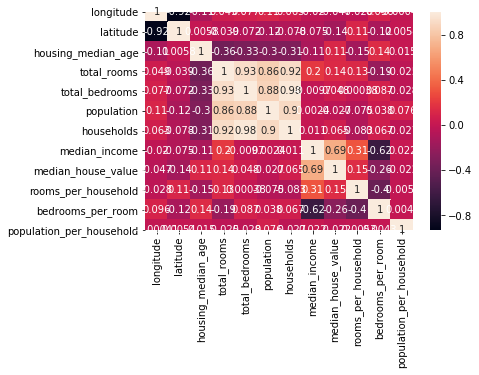

In [39]:
sns.heatmap(corr_mat, annot=True)

## 3. Prepare the data for ML algorithms <a name="third-bullet"></a>

In [40]:
housing = strat_train_set.drop("median_house_value", axis=1)    # drop() creates a copy of the data
housing_labels = strat_train_set["median_house_value"].copy()

### Cleaning
- missing values

In [41]:
from sklearn.impute import SimpleImputer

In [42]:
imputer = SimpleImputer(strategy='median')

In [43]:
# separate into numerical and object values
housing_num = housing.drop("ocean_proximity", axis=1)

In [44]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [45]:
X = imputer.fit_transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
16508,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
16509,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
16510,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [46]:
# categorical part
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

In [47]:
## One way to do this...
# step 1
encoder = LabelEncoder()
housing_cat_encoded = encoder.fit_transform(housing['ocean_proximity'])
print(housing_cat_encoded)

# step 2
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))    # sparse matrix
# print(housing_cat_1hot)

[0 0 4 ... 1 0 3]


C:\Users\yzhou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [48]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing['ocean_proximity'].values.reshape(-1, 1)) 
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [49]:
# Alternative way to do this... (not good in sklearn >= 0.19.0)
# encoder = LabelBinarizer()
# housing_cat_1hot = encoder.fit_transform(housing["ocean_proximity"])
# housing_cat_1hot

### Custom transformers 
Create a class that has
- fit(): returning *self*
- transform()
- fit_transform() methods by inheriting from TransformerMixin.
- Also inherit from BaseEstimator, useful for hyperparameter tuning.

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [51]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """ Custom attributes adder.
    """
    def __init__(self, add_bedroom_per_room=True):
        self.add_bedroom_per_room = add_bedroom_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedroom_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household] 

In [52]:
attr_adder = CombinedAttributesAdder(add_bedroom_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [53]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

### Feature scaling

### Pipelines - replacing all above steps

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

In [55]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """ Enables scikit-learn to handle pandas dataframes.
    """
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [56]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# 1) numerical columnss
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# 2) categorical values
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
#     ('label_binarizer', LabelBinarizer()),
    ('encoder', OneHotEncoder()),
])

# 3) combined
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [57]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

## 4. Select and Train a model <a name="fourth-bullet"></a>

In [142]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [143]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [144]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions) ** .5
lin_rmse

68628.19819848923

RMSE too large: underfitted the model.
- Try selecting a more powerfull model, feed better features, or reduce the constraints.

In [145]:
from sklearn.tree import DecisionTreeRegressor

In [146]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [147]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions) ** .5
tree_rmse

0.0

Zero RMSE: Must be overfitting.

In [93]:
# RF
from sklearn.ensemble import RandomForestRegressor

In [148]:
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared, housing_labels)

C:\Users\yzhou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [149]:
housing_predictions = rf_reg.predict(housing_prepared)
rf_rmse = mean_squared_error(housing_labels, housing_predictions) ** .5
rf_rmse

21958.479946991076

### Cross-validation

In [150]:
def display_scores(sc):
    print("Scores: ", sc)
    print("Mean: ", sc.mean())
    print("Standard deviation: ", sc.std())

In [151]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
rmse_scores_tree = np.sqrt(-scores)
display_scores(rmse_scores_tree)

Scores:  [69518.89026929 66547.7975682  70645.59158884 68774.44505385
 71522.95443894 75799.40462996 71764.78716247 70888.87992366
 77043.24218102 69942.65795969]
Mean:  71244.8650775945
Standard deviation:  2967.1310230142535


In [152]:
# for linear reg
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
rmse_scores_lin = np.sqrt(-lin_scores)
display_scores(rmse_scores_lin)

Scores:  [66782.73840648 66960.11770454 70347.95253774 74739.57050136
 68031.1338941  71193.84183701 64969.63057974 68281.61137785
 71552.9156973  67665.10083676]
Mean:  69052.46133728891
Standard deviation:  2731.6740318925777


In [153]:
rf_scores = cross_val_score(rf_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
rmse_scores_rf = np.sqrt(-rf_scores)
display_scores(rmse_scores_rf)

Scores:  [52387.99186201 50410.05444047 52657.4079599  55083.59583073
 52568.26372506 56330.21152457 51604.11593343 50061.69332878
 55867.42302742 53105.73389706]
Mean:  53007.6491529435
Standard deviation:  2040.4084312867656


Compare this CV mean with training error: still overfitting...

### Save models

In [60]:
from datetime import datetime, date
from sklearn.externals import joblib

C:\Users\yzhou\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [155]:
joblib.dump(rf_reg, "rf_reg_"+date.today().strftime("%m%d%y")+".pkl")

['rf_reg_012120.pkl']

In [56]:
# test = joblib.load("./rf_reg_011720.pkl")
# test

## 5. Fine-tuning <a name="fifth-bullet"></a>

### Grid Search of hyperparameters
Takes quite a long time: (# of combinations)*cv

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [96]:
param_grid

[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

In [97]:
rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [98]:
# best?
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [99]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [100]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63583.01925810805 {'max_features': 2, 'n_estimators': 3}
55380.89346963713 {'max_features': 2, 'n_estimators': 10}
52864.0057383134 {'max_features': 2, 'n_estimators': 30}
60534.81070255391 {'max_features': 4, 'n_estimators': 3}
52903.00670850302 {'max_features': 4, 'n_estimators': 10}
50502.05401729788 {'max_features': 4, 'n_estimators': 30}
59126.77378986117 {'max_features': 6, 'n_estimators': 3}
52062.261347286425 {'max_features': 6, 'n_estimators': 10}
50018.217800616265 {'max_features': 6, 'n_estimators': 30}
59531.78253151416 {'max_features': 8, 'n_estimators': 3}
52190.21212534285 {'max_features': 8, 'n_estimators': 10}
50112.71379495069 {'max_features': 8, 'n_estimators': 30}
63070.31112941615 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53709.38400125982 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60595.93891543897 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52877.54248924912 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

Now the best RMSE is less than the training error - successfully fine-tuned the random forest model!

### Randomized Search

In [157]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import *

In [159]:
distributions = {
    'n_estimators': randint(10, 100),
    'max_features': randint(2, 9),
}
random_search = RandomizedSearchCV(rf_reg, distributions, n_iter=20, cv=5, scoring='neg_mean_squared_error')
random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=N...


In [160]:
random_search.best_params_

{'max_features': 7, 'n_estimators': 73}

### Analyze the best models

In [101]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.48677477e-02, 7.18646408e-02, 4.39872012e-02, 1.86746848e-02,
       1.66517928e-02, 1.77906377e-02, 1.53322414e-02, 3.31471964e-01,
       7.42777492e-02, 1.10026125e-01, 5.37239281e-02, 1.20628002e-02,
       1.51572576e-01, 3.93398165e-05, 1.98413911e-03, 5.67243273e-03])

In [102]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(*encoder.categories_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.33147196372264504, 'median_income'),
 (0.151572576098688, 'INLAND'),
 (0.11002612468261383, 'pop_per_hhold'),
 (0.07486774768503153, 'longitude'),
 (0.07427774921329616, 'rooms_per_hhold'),
 (0.07186464077664761, 'latitude'),
 (0.053723928085608726, 'bedrooms_per_room'),
 (0.04398720116141616, 'housing_median_age'),
 (0.01867468475743044, 'total_rooms'),
 (0.017790637698598212, 'population'),
 (0.0166517928415359, 'total_bedrooms'),
 (0.015332241386189058, 'households'),
 (0.012062800232851532, '<1H OCEAN'),
 (0.005672432731660379, 'NEAR OCEAN'),
 (0.0019841391093161644, 'NEAR BAY'),
 (3.9339816471251994e-05, 'ISLAND')]

May want to drop some less useful features, and re-run the model.

### Evaluate on the test set

In [190]:
final_model = grid_search.best_estimator_

In [191]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [193]:
X_test_prepared = full_pipeline.transform(X_test)
final_pred = final_model.predict(X_test_prepared)

In [194]:
final_rmse = mean_squared_error(y_test, final_pred) ** .5
final_rmse

47972.34677046268

# Exercise
Building a SVM regressor with pipeline

In [58]:
from sklearn.svm import SVR

In [221]:
param_grid = [
    {'kernel': ['linear'], 'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000]},
    {'kernel': ['rbf'], 'C': [1, 3, 10, 30, 100, 300, 1000], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3]},
]

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, 
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.1min
C:\Users\yzhou\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 14.5min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 23.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=4,
             param_grid=[{'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000],
                          'kernel': ['linear']},
                         {'C': [1, 3, 10, 30, 100, 300, 1000],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [222]:
grid_search.best_params_

{'C': 30000, 'kernel': 'linear'}

In [225]:
rmse = (-grid_search.best_score_) ** .5
rmse

70363.90313964167

### *Use reciprocal (aka. log-uniform) distribution when you don't have a clue of what the target scale is.*

In [227]:
# fine-tuning
param_dist = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0),
}

random_search = RandomizedSearchCV(svr, param_dist, n_iter=50, cv=5, 
                                   scoring='neg_mean_squared_error',
                                   verbose=2, n_jobs=4, random_state=42)
random_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.8min
C:\Users\yzhou\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 19.0min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 31.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=50, n_jobs=4,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020DA8B94A48>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020D99C800C8>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [228]:
random_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [229]:
rmse = (-random_search.best_score_) ** .5
rmse

54767.99053704408

In [231]:
# joblib.dump(random_search, 'randomized_search_result.pkl')

['randomized_search_result.pkl']

In [122]:
random_search = joblib.load('./randomized_search_result.pkl')

In [126]:
random_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

### Adding a transformer

In [111]:
def top_k_indices(x, k):
    return np.sort(np.argpartition(np.array(x), -k)[-k:])

In [112]:
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importance, k):
        self.feature_importance = feature_importance
        self.k = k
        
    def fit(self, X, y=None):
        self.feature_indices_ = top_k_indices(self.feature_importance, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.feature_indices_]

In [114]:
k = 5

In [117]:
top_k_features_ind = top_k_indices(feature_importance, k)
np.array(attributes)[top_k_features_ind]

array(['longitude', 'median_income', 'rooms_per_hhold', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [118]:
# pipeline
prep_and_feature_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importance, k)),
])

In [130]:
prep_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importance, k)),
    ('svm_reg', SVR(**random_search.best_params_))
])

In [133]:
prep_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['longitude',
                                                                                                     'latitude',
                                                                                                     'housing_median_age',
                                                                                                     'total_rooms',
                                                                                                     'total_bedrooms',
                                                                                                     'po

In [138]:
some_data = housing.iloc[:10]
some_labels = housing_labels.iloc[:10]

In [139]:
pd.DataFrame({'prediction': prep_select_and_predict_pipeline.predict(some_data),
              'actual': some_labels})

,prediction,actual
17606,193843.863734,286600.0
18632,334130.165000,340600.0
14650,170719.747632,196900.0
3230,54378.612394,46300.0
3555,201204.189988,254500.0
19480,118909.089403,127900.0
8879,455915.726769,500001.0
13685,247944.666303,140200.0
4937,115747.275207,95000.0
4861,119672.087082,500001.0


# TESTS

In [57]:
# Test np.c_ function
ta = np.array([[1, 2, 3], [4, 5, 6]])
tb = np.array([7, 8]).reshape(-1, 1)
print(ta.shape)
print(tb.shape)

combined=np.c_[ta, tb]
print(combined.shape)

(2, 3)
(2, 1)
(2, 4)
